In [1]:
import random
import os

from datetime import datetime

import numpy as np
import pandas as pd
from autogluon.tabular import TabularPredictor
# from autogluon.core.utils.utils import set_seed

In [2]:
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)

In [3]:
#1. 데이터 로드

train_df = pd.read_csv('train.csv')
# ID 컬럼이 있다면 미리 제거 (예시)
train_df = train_df.drop(columns=['ID'])
test_df =pd.read_csv('test.csv')
target = '임신 성공 여부'


고령 여부 & 나이 순서: 노화 +임신 성공

이식 비중: 생성된 배아 중 실제 이식에 적합한 우수 배아의 비율을 확인

난자 배아 변환율: 채취된 난자-> 건강한 배아 발달 = '세포 수준의 효율'

high_egg_count: 난자 과채취로 인한 질 저하 및 부작용

is_experienced: 과거 출산 성공 경험을 통해 신체의 임신 유지 능력을 입증

출산 효율 점수: 통계적으로 성공률이 높은 최적의 과거 출산 횟수 구간

나이 경험 상호작용: 고령 + 출산 경험

past_success_rate: 과거 임신 시도+ 임신 성공

In [4]:
def derive_features(df):
    # --- 0. 숫자형 변환 (더 강력하게!) ---
    num_cols = ['저장된 신선 난자 수', '이식된 배아 수', '저장된 배아 수']
    for col in num_cols:
        if col in df.columns:
            # 문자열을 숫자로 바꾸고, 바꿀 수 없는 건 0으로 채움
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # --- 1. 나이 관련 변수 ---
    elderly_categories = ['만35-37세', '만38-39세', '만40-42세', '만43-44세', '만45-50세']
    df['고령 여부'] = df['시술 당시 나이'].isin(elderly_categories).astype(int)

    age_order = {'만18-34세': 1, '만35-37세': 2, '만38-39세': 3, '만40-42세': 4, '만43-44세': 5, '만45-50세': 6, '알 수 없음': 0}
    df['나이_순서'] = df['시술 당시 나이'].map(age_order).fillna(0).astype(int)
    
    # --- 2. 배아 및 난자 효율 ---
    # 수치형 확인 후 연산
    df['이식 비중'] = df['이식된 배아 수'] / (df['이식된 배아 수'] + df['저장된 배아 수'] + 1e-6)
    df['난자_배아_변환율'] = df['저장된 배아 수'] / (df['저장된 신선 난자 수'] + 1e-6)
    df['high_egg_count'] = (df['저장된 신선 난자 수'].astype(float) > 15).astype(int)

    # --- 3. 출산 경험 바이브 ---
    preg_col = '총 임신 횟수' if '총 임신 횟수' in df.columns else '과거 임신 횟수'
    birth_col = '총 출산 횟수' if '총 출산 횟수' in df.columns else '과거 출산 횟수'

    if birth_col in df.columns:
        # 이 부분이 핵심! 확실하게 float으로 변환 후 비교
        df[birth_col] = pd.to_numeric(df[birth_col], errors='coerce').fillna(0)
        df['is_experienced'] = (df[birth_col].astype(float) > 0).astype(int)
        
        def get_efficiency(n):
            n = float(n) # 안전하게 변환
            if n == 0: return 0.8
            if 1 <= n <= 3: return 1.2
            return 0.6
        df['출산_효율_점수'] = df[birth_col].apply(get_efficiency)
        
        # 나이_순서가 0일 때를 대비해 분모에 1.1 등 미세한 값을 더함
        df['나이_경험_상호작용'] = df['is_experienced'].astype(float) / (df['나이_순서'].astype(float) + 1.0)

    if preg_col in df.columns and birth_col in df.columns:
        df[preg_col] = pd.to_numeric(df[preg_col], errors='coerce').fillna(0)
        df['past_success_rate'] = df[birth_col].astype(float) / (df[preg_col].astype(float) + 1e-6)

    return df

# 실행
train_df = derive_features(train_df)
test_df =derive_features(test_df)

    

In [5]:
#3. 모델 학습 설정

predictor = TabularPredictor(
    label=target,
    eval_metric ='roc_auc',
    path = 'ag_models_out',
).fit(
    train_data=train_df,
    time_limit=3600,
    presets = 'best_quality',
    ag_args_fit={'num_gpus':1},
    num_bag_folds=5,
    refit_full=True
)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.13.5
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 25.2.0: Tue Nov 18 21:09:40 PST 2025; root:xnu-12377.61.12~1/RELEASE_ARM64_T6000
CPU Count:          10
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
GPU Count:          WARNING: Exception was raised when calculating GPU count (AssertionError)
Memory Avail:       3.93 GB / 16.00 GB (24.6%)
Disk Space Avail:   296.60 GB / 460.43 GB (64.4%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether t

In [6]:
#4. 예측 (Test Data)
pred_probs = predictor.predict_proba(test_df)
final_probs = pred_probs.iloc[:,1]

In [7]:
# 리더보드 보기 
lb= predictor.leaderboard(silent =True)
display(lb.sort_values(by='score_val',ascending =False))

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.738620,roc_auc,26.588718,2468.205738,0.042474,7.587865,2,True,8
1,NeuralNetTorch_BAG_L1,0.737036,roc_auc,3.785955,2114.935266,3.785955,2114.935266,1,True,5
2,NeuralNetTorch_r79_BAG_L1,0.735224,roc_auc,4.155370,316.396101,4.155370,316.396101,1,True,6
3,ExtraTreesEntr_BAG_L1,0.732443,roc_auc,6.079729,8.853669,6.079729,8.853669,1,True,4
4,ExtraTreesGini_BAG_L1,0.731500,roc_auc,5.628634,8.376865,5.628634,8.376865,1,True,3
5,RandomForestEntr_BAG_L1,0.730959,roc_auc,6.044558,9.981759,6.044558,9.981759,1,True,2
6,RandomForestGini_BAG_L1,0.730558,roc_auc,6.480633,10.451078,6.480633,10.451078,1,True,1
7,ExtraTrees_r42_BAG_L1,0.718837,roc_auc,2.965670,18.199758,2.965670,18.199758,1,True,7
8,ExtraTrees_r42_BAG_L1_FULL,NaN,roc_auc,2.965670,18.199758,2.965670,18.199758,1,True,15
9,ExtraTreesGini_BAG_L1_FULL,NaN,roc_auc,5.628634,8.376865,5.628634,8.376865,1,True,11


In [8]:
# 피처 중요도
fi =predictor.feature_importance(data=train_df.sample(n=min(5000,len(train_df)),random_state=42))
display(fi.sort_values(by='p_value',ascending=True).head(30))


These features in provided data are not utilized by the predictor and will be ignored: ['불임 원인 - 여성 요인', '불임 원인 - 정자 면역학적 요인', '총 임신 횟수', '총 출산 횟수', 'is_experienced', '출산_효율_점수', '나이_경험_상호작용', 'past_success_rate']
Computing feature importance via permutation shuffling for 68 features using 5000 rows with 5 shuffle sets...
	753.25s	= Expected runtime (150.65s per shuffle set)
	310.67s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
배아 이식 경과일,0.051201,0.000616,2.516737e-09,5,0.052469,0.049932
IVF 시술 횟수,0.017006,0.000212,2.911926e-09,5,0.017443,0.016569
클리닉 내 총 시술 횟수,0.015774,0.000236,6.019273e-09,5,0.016260,0.015288
파트너 정자와 혼합된 난자 수,0.019518,0.000374,1.615571e-08,5,0.020288,0.018749
혼합된 난자 수,0.022959,0.000508,2.869094e-08,5,0.024005,0.021914
특정 시술 유형,0.011935,0.000307,5.258480e-08,5,0.012567,0.011302
미세주입 후 저장된 배아 수,0.004832,0.000125,5.366436e-08,5,0.005090,0.004575
불명확 불임 원인,0.007526,0.000199,5.849694e-08,5,0.007935,0.007116
불임 원인 - 배란 장애,0.005779,0.000160,6.979483e-08,5,0.006108,0.005451
미세주입된 난자 수,0.015515,0.000430,7.067936e-08,5,0.016400,0.014630


In [9]:
#5. 제출파일

submission = pd.read_csv('sample_submission.csv')
submission['probability']=final_probs.values

# 현재 시간 가져오기 (예: 0206_1031)
now = datetime.now().strftime('%m%d_%H%M')
file_name = f"{now}_submission.csv"
submission.to_csv(file_name, index=False)

print(f"학습 및 예측이 완료되었습니다. 결과가 {file_name}에 저장되었습니다.")

학습 및 예측이 완료되었습니다. 결과가 0209_1608_submission.csv에 저장되었습니다.


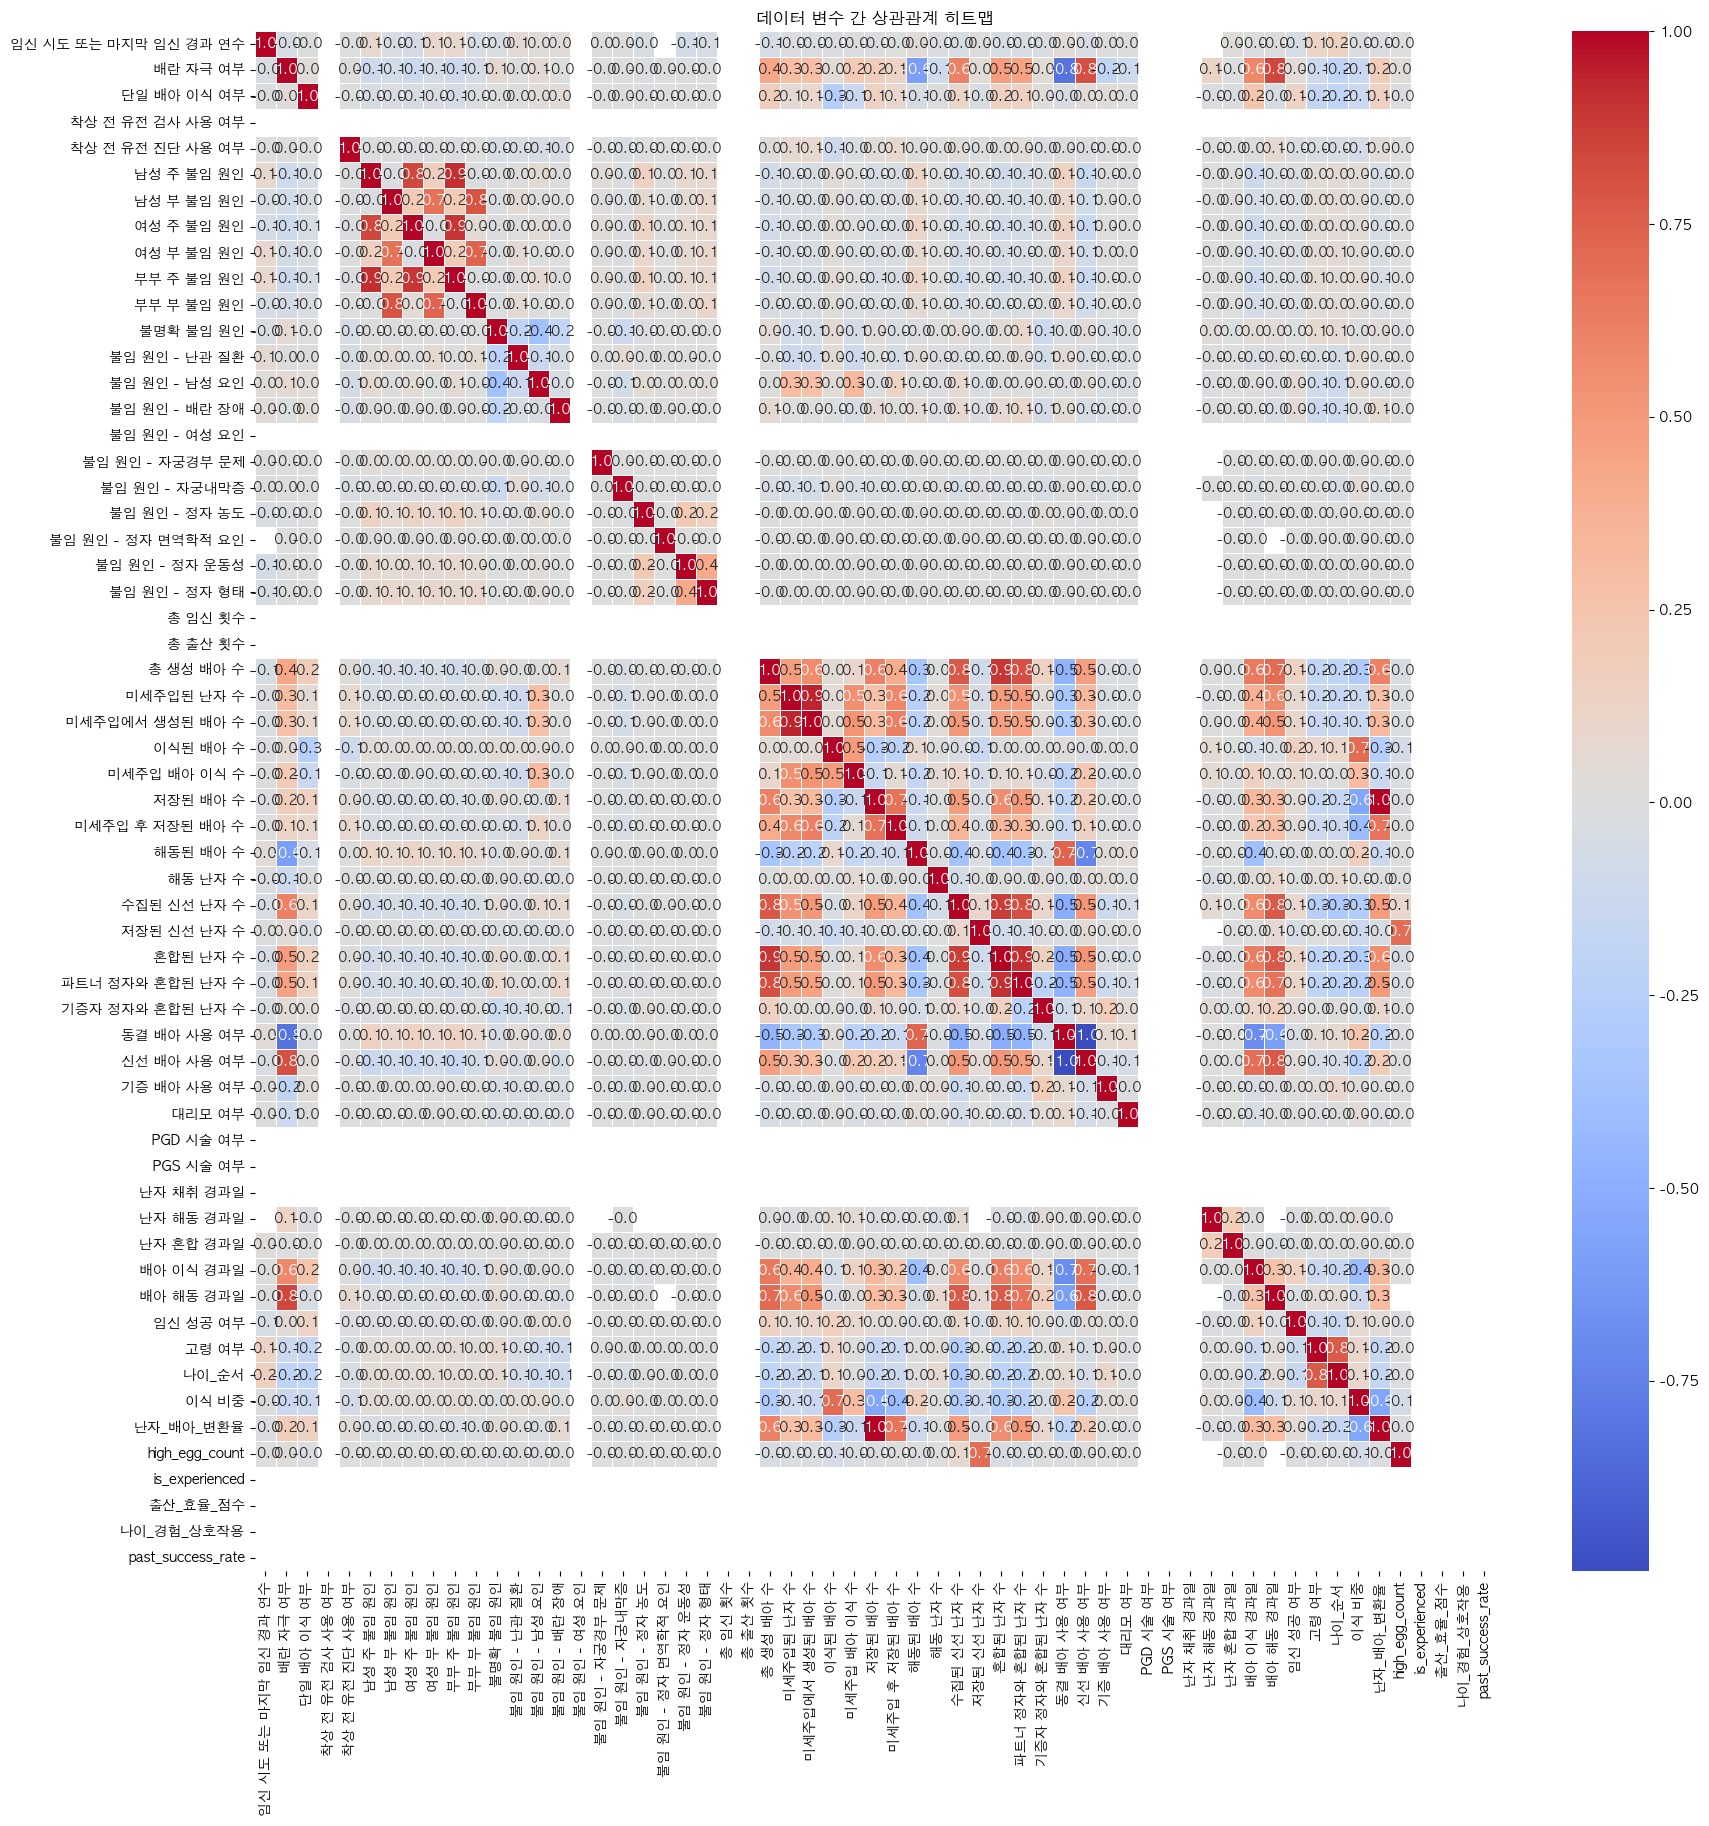

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정 (맥북 기준) - 차트에 한글이 깨지지 않게 해줍니다.
plt.rc('font', family='AppleGothic') 
plt.rcParams['axes.unicode_minus'] = False

def draw_heatmap(df):
    # 1. 숫자형 데이터만 골라내기 (글자로 된 데이터는 상관계수를 구할 수 없어요)
    numeric_df = df.select_dtypes(include=['number'])
    
    # 2. 상관계수 계산 (Correlation)
    corr = numeric_df.corr()
    
    # 3. 히트맵 그리기
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr, 
                annot=True,      # 칸 안에 숫자 표시
                fmt='.1f',       # 소수점 둘째 자리까지
                cmap='coolwarm', # 색상 (빨간색은 양의 상관관계, 파란색은 음의 상관관계)
                linewidths=0.5)
    
    plt.title('데이터 변수 간 상관관계 히트맵')
    plt.show()

# 사용법: 
draw_heatmap(train_df)

In [11]:
# 'target' 컬럼과 다른 컬럼들 간의 상관관계만 추출
correlations = train_df.select_dtypes(include=['number']).corr()['임신 성공 여부'].sort_values(ascending=False)*100
print(correlations)

임신 성공 여부                 100.000000
이식된 배아 수                  16.303045
배아 이식 경과일                 14.859045
총 생성 배아 수                 14.611633
단일 배아 이식 여부               13.263474
혼합된 난자 수                  11.613557
파트너 정자와 혼합된 난자 수          10.490161
미세주입에서 생성된 배아 수            9.027481
수집된 신선 난자 수                8.302330
미세주입 배아 이식 수               7.435092
미세주입된 난자 수                 7.011668
이식 비중                      6.372554
난자_배아_변환율                  3.963851
저장된 배아 수                   3.909863
불임 원인 - 남성 요인              3.790842
배란 자극 여부                   3.321184
신선 배아 사용 여부                3.175463
기증자 정자와 혼합된 난자 수           2.618090
불임 원인 - 배란 장애              2.502099
미세주입 후 저장된 배아 수            2.173721
기증 배아 사용 여부                1.493863
대리모 여부                     0.402290
불명확 불임 원인                  0.147265
불임 원인 - 난관 질환             -0.054434
불임 원인 - 정자 농도             -0.062618
불임 원인 - 정자 면역학적 요인        -0.116570
불임 원인 - 정자 형태             -0.186596
해동 난자 수                   -0

These features in provided data are not utilized by the predictor and will be ignored: ['불임 원인 - 여성 요인', '불임 원인 - 정자 면역학적 요인', '총 임신 횟수', '총 출산 횟수', 'is_experienced', '출산_효율_점수', '나이_경험_상호작용', 'past_success_rate']
Computing feature importance via permutation shuffling for 68 features using 5000 rows with 5 shuffle sets...
	1027.73s	= Expected runtime (205.55s per shuffle set)
	338.14s	= Actual runtime (Completed 5 of 5 shuffle sets)


상위 30개 중요 변수:


,importance,stddev,p_value,n,p99_high,p99_low
이식된 배아 수,0.074008,0.004612,1.800300e-06,5,0.083504,0.064512
배아 이식 경과일,0.051201,0.000616,2.516737e-09,5,0.052469,0.049932
총 생성 배아 수,0.045825,0.003130,2.594591e-06,5,0.052269,0.039381
나이_순서,0.033689,0.001484,4.511308e-07,5,0.036746,0.030633
이식 비중,0.025508,0.001852,3.308075e-06,5,0.029320,0.021695
시술 시기 코드,0.023090,0.000986,3.973048e-07,5,0.025119,0.021061
수집된 신선 난자 수,0.022972,0.000661,8.205463e-08,5,0.024333,0.021612
혼합된 난자 수,0.022959,0.000508,2.869094e-08,5,0.024005,0.021914
시술 당시 나이,0.020273,0.000843,3.573183e-07,5,0.022008,0.018538
파트너 정자와 혼합된 난자 수,0.019518,0.000374,1.615571e-08,5,0.020288,0.018749


p-value 0.5 이하인 변수들 (가장 유의미한 순서):


,importance,stddev,p_value,n,p99_high,p99_low
배아 이식 경과일,0.051201,0.000616,2.516737e-09,5,0.052469,0.049932
IVF 시술 횟수,0.017006,0.000212,2.911926e-09,5,0.017443,0.016569
클리닉 내 총 시술 횟수,0.015774,0.000236,6.019273e-09,5,0.016260,0.015288
파트너 정자와 혼합된 난자 수,0.019518,0.000374,1.615571e-08,5,0.020288,0.018749
혼합된 난자 수,0.022959,0.000508,2.869094e-08,5,0.024005,0.021914
특정 시술 유형,0.011935,0.000307,5.258480e-08,5,0.012567,0.011302
미세주입 후 저장된 배아 수,0.004832,0.000125,5.366436e-08,5,0.005090,0.004575
불명확 불임 원인,0.007526,0.000199,5.849694e-08,5,0.007935,0.007116
불임 원인 - 배란 장애,0.005779,0.000160,6.979483e-08,5,0.006108,0.005451
미세주입된 난자 수,0.015515,0.000430,7.067936e-08,5,0.016400,0.014630


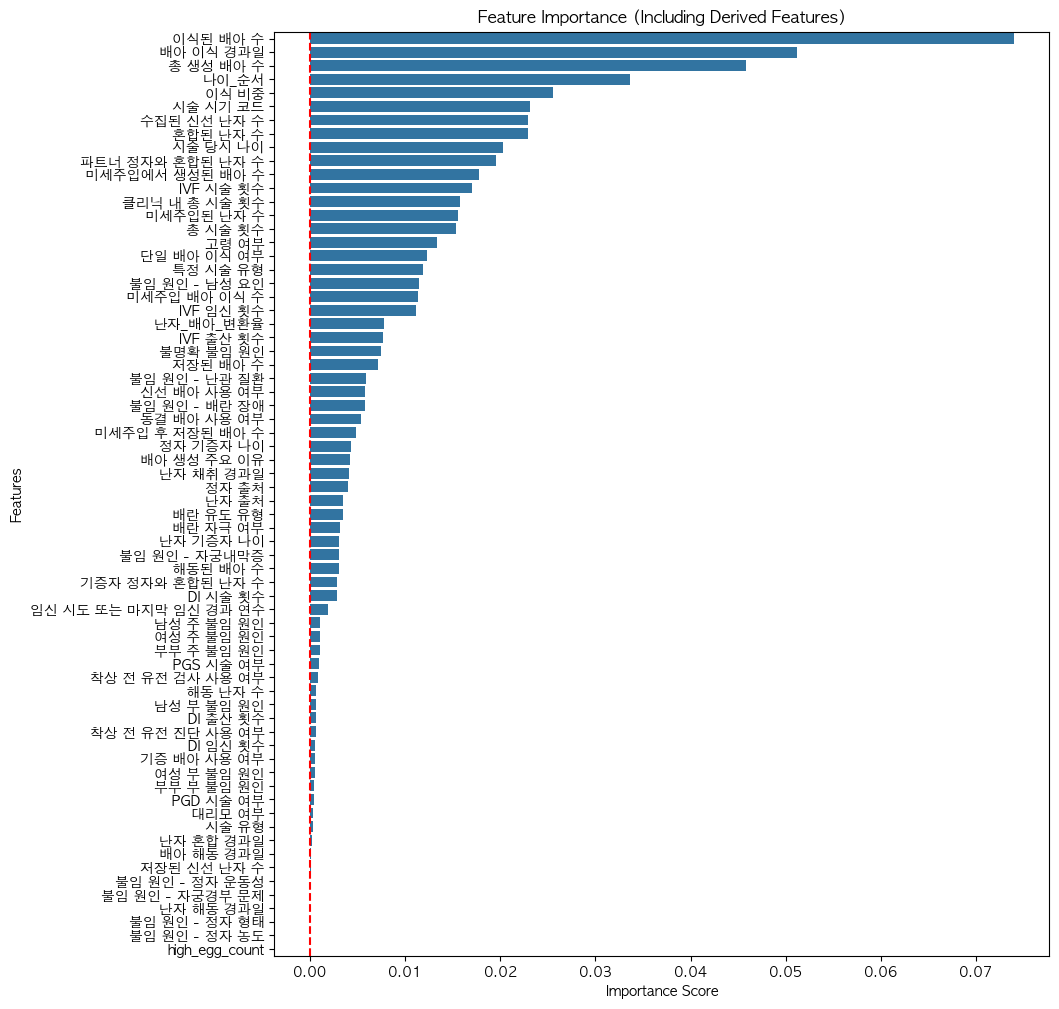

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 피처 중요도 계산 
fi = predictor.feature_importance(data=train_df.sample(n=min(5000, len(train_df)), random_state=42))

# 2. 결과 출력 (상위 30개)
print("상위 30개 중요 변수:")
display(fi.head(30))

# 1. p-value가 0.5 이하인 데이터만 필터링
fi_filtered = fi[fi['p_value'] <= 0.5]

# 2. p-value가 낮은 순서(오름차순, ascending=True)로 정렬
# (낮을수록 더 중요한 변수이기 때문입니다!)
fi_sorted = fi_filtered.sort_values(by='p_value', ascending=True)

# 3. 결과 출력 (상위 30개)
print("p-value 0.5 이하인 변수들 (가장 유의미한 순서):")
display(fi_sorted.head(30))

# 3. 시각화 (막대 그래프)
plt.figure(figsize=(10, 12))
# 중요도(importance)가 높은 순서대로 그립니다.
sns.barplot(x=fi['importance'], y=fi.index)

plt.title('Feature Importance (Including Derived Features)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.axvline(x=0, color='r', linestyle='--') # 0 지점에 선 긋기
plt.show()

In [ ]:
from autogluon.tabular import TabularPredictor

# 1. 모델 설정 (CatBoost 비중 조절 및 가벼운 모델 위주)
# CatBoost는 포함하되, 다른 모델(LightGBM, XGBoost)과 균형을 맞춥니다.
hyperparameters = {
    'GBM': [
        {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
        {}, # 기본 LightGBM
    ],
    'XGB': {},
    'CAT': {}, # CatBoost 포함
    'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini'}}, 
           {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr'}}],
}

# 2. 앙상블 학습 실행
predictor = TabularPredictor(
    label='target_column_name', # 실제 정답 컬럼명으로 수정하세요
    eval_metric='roc_auc'       # 난임 예측은 보통 AUC를 많이 사용합니다
).fit(
    train_data=train_df,
    time_limit=900,            # run_time 조절 (예: 1시간 제한)
    num_stack_levels=1,         # stack_level 제한 (가볍게 구성)
    hyperparameters=hyperparameters,
    holdout_frac=0.2,           # 검증 데이터 비율
    ag_args_fit={'stopping_metric': 'roc_auc'}
)

# 3. 모델별 가중치 확인 (앙상블 내 CatBoost 비중 체크)
summary = predictor.fit_summary()
print("모델 앙상블 가중치 확인:")
print(predictor.model_best_weights())